In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import thomsonpy.thomson_scattering.thomson_scattering_tools as thtools
import thomsonpy.data_management.formatter as fmt
import thomsonpy.data_management.fragmenter as frm
import thomsonpy.data_management.octree.octree as octr
import thomsonpy.data_management.visualizer as vis
import thomsonpy.config.paths as paths
import thomsonpy.config.solar_imager_params as sip
import thomsonpy.config.thomson_scattering_params as tsp
import thomsonpy.constants.units as units

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
prefix = "../../"
predsci_data_filepath = prefix + paths.PREDSCI_DATA_PATH + paths.PREDSCI_FILENAME

data_filepaths = [f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}_1.data",
                  f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}_2.data",
                  f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}_3.data",
                  f"{prefix}{paths.OCTREE_DATA_PATH}{os.path.splitext(paths.PREDSCI_FILENAME)[0]}_4.data"]

octree_paths = [f"{prefix}{paths.OCTREES_PATH}octree_1.oct",
                f"{prefix}{paths.OCTREES_PATH}octree_2.oct",
                f"{prefix}{paths.OCTREES_PATH}octree_3.oct",
                f"{prefix}{paths.OCTREES_PATH}octree_4.oct"]

In [ ]:
# DATA FRAGMENTING
print("\nStarting data formatting and fragmenting...")

ne_raw = frm.get_ne_raw(predsci_data_filepath)
data_radial = frm.get_ne_raw_coords(predsci_data_filepath, "radial")
data_theta = frm.get_ne_raw_coords(predsci_data_filepath, "theta")
data_phi = frm.get_ne_raw_coords(predsci_data_filepath, "phi")

def selection1(r, theta, phi, ne):
    """
    First quadrant
    """
    cartesian_coords = fmt.spherical_to_cartesian(r, theta, phi)
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    limit = 3
    return (x <= limit and x >= 0 and
            y <= limit and y >= 0 and
            z <= limit / 2 and z >= -limit / 2)

def selection2(r, theta, phi, ne):
    """
    Second quadrant
    """
    cartesian_coords = fmt.spherical_to_cartesian(r, theta, phi)
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    limit = 3
    return (x <= 0 and x >= -limit and
            y <= limit and y >= 0 and
            z <= limit / 2 and z >= -limit / 2)
    
def selection3(r, theta, phi, ne):
    """
    Third quadrant
    """
    cartesian_coords = fmt.spherical_to_cartesian(r, theta, phi)
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    limit = 3
    return (x <= 0 and x >= -limit and
            y <= 0 and y >= -limit and
            z <= limit / 2 and z >= -limit / 2)
    
def selection4(r, theta, phi, ne):
    """
    Fourth qudrant
    """
    cartesian_coords = fmt.spherical_to_cartesian(r, theta, phi)
    x = cartesian_coords[0]
    y = cartesian_coords[1]
    z = cartesian_coords[2]
    limit = 3
    return (x <= limit and x >= 0 and
            y <= 0 and y >= -limit and
            z <= limit / 2 and z >= -limit / 2)
    
for i in range(2, 4):
    
    selection = None
    if i == 0:
        selection = selection1
    elif i == 1:
        selection = selection2
    elif i == 2:
        selection = selection3
    elif i == 3:
        selection = selection4
        
    ini_time = time.perf_counter()
    octree_data = []
    octree_data = frm.fragment(selection, fmt.apply_octree_data_format, ne_raw, data_radial, data_theta, data_phi)
    fin_time = time.perf_counter()

    print("Data formatting and fragmentation in", fin_time - ini_time, "seconds.")

    fmt.dump(data_filepaths[i], octree_data)
    print(f"Stored data for octree at {paths.OCTREE_DATA_PATH}")

    print("Octree will have", len(octree_data), "points")

In [ ]:
vis.vis_octree_data(data_filepaths[0])

In [ ]:
vis.vis_ne(data_filepaths[0])

In [ ]:
import os
import time

import thomsonpy.config.octree_params as op

## OCTREE CREATION AND STORAGE
min_v = [op.MIN_1, op.MIN_2, op.MIN_3, op.MIN_4]
max_v = [op.MAX_1, op.MAX_2, op.MAX_3, op.MAX_4]

for i in range(2, 4):
    # Loading data...
    octree_data = fmt.load(data_filepaths[i])
    print("Loaded octree data:", len(octree_data), "points.")
    octree = 0
    # Creating octree...
    print("Creating octree with params:")
    print("MAX_LEVEL =", op.MAX_LEVEL)
    print("MAX_DATA =", op.MAX_DATA)
    print("MIN_V =", min_v[i])
    print("MAX_V =", max_v[i])
    ini_time = time.perf_counter()
    octree = octr.Octree(op.MAX_LEVEL, op.MAX_DATA, octree_data, min_v[i], max_v[i])
    fin_time = time.perf_counter()
    print("Octree " + str(i + 1) + " built in", str((fin_time - ini_time) / 60), "minutes.")
    octr.Octree.save(octree, octree_paths[i])
    print("Octree " + str(i + 1) + " created at", paths.OCTREES_PATH)

In [ ]:
octree = octr.Octree.load(octree_paths[3])
vis.vis_octree(octree)

In [3]:
"""
Starts execution of solar corona modeling with the Predictive Science model.
"""
print("Imaging between", sip.IMAGE_MIN * units.METERS_TO_RSOL, "RSol and" , sip.IMAGE_MAX * units.METERS_TO_RSOL, "RSol.")
print("Resolution = ", sip.IMAGE_RESOLUTION / 1000, " km (", sip.IMAGE_NUM_POINTS, "x", sip.IMAGE_NUM_POINTS, ").")
x_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS) # de - a +
print(x_values * units.METERS_TO_RSOL)
y_values = np.linspace(sip.MIN_COORD, sip.MAX_COORD, sip.IMAGE_NUM_POINTS)[::-1] # de + a -
print(y_values * units.METERS_TO_RSOL)
model = np.zeros((sip.IMAGE_NUM_POINTS, sip.IMAGE_NUM_POINTS))
print("# Numeric integral steps =", tsp.NUM_Z)

Imaging between [-3. -3.] RSol and [3. 3.] RSol.
Resolution =  50000.0  km ( 84 x 84 ).
[-3.         -2.92771084 -2.85542169 -2.78313253 -2.71084337 -2.63855422
 -2.56626506 -2.4939759  -2.42168675 -2.34939759 -2.27710843 -2.20481928
 -2.13253012 -2.06024096 -1.98795181 -1.91566265 -1.84337349 -1.77108434
 -1.69879518 -1.62650602 -1.55421687 -1.48192771 -1.40963855 -1.3373494
 -1.26506024 -1.19277108 -1.12048193 -1.04819277 -0.97590361 -0.90361446
 -0.8313253  -0.75903614 -0.68674699 -0.61445783 -0.54216867 -0.46987952
 -0.39759036 -0.3253012  -0.25301205 -0.18072289 -0.10843373 -0.03614458
  0.03614458  0.10843373  0.18072289  0.25301205  0.3253012   0.39759036
  0.46987952  0.54216867  0.61445783  0.68674699  0.75903614  0.8313253
  0.90361446  0.97590361  1.04819277  1.12048193  1.19277108  1.26506024
  1.3373494   1.40963855  1.48192771  1.55421687  1.62650602  1.69879518
  1.77108434  1.84337349  1.91566265  1.98795181  2.06024096  2.13253012
  2.20481928  2.27710843  2.34939759  

[42, 0, 0, 42]
[84, 42, 42, 84]
[0, 0, 42, 42]
[42, 42, 84, 84]
Num points = 7056
Loading octree...
Octree loaded.
Progress 2.8344671201814062 %
Progress 5.6689342403628125 %
Progress 8.503401360544217 %
Progress 11.337868480725625 %
Progress 14.17233560090703 %
Progress 17.006802721088434 %
Progress 19.841269841269842 %
Progress 22.67573696145125 %


/tmp/ipykernel_10489/1985886991.py:47: RuntimeWarning: divide by zero encountered in log
  model_log = np.log(model) / np.log(7)


Loading octree...
Octree loaded.
Progress 25.510204081632654 %
Progress 28.34467120181406 %
Progress 31.179138321995463 %
Progress 34.01360544217687 %
Progress 36.848072562358276 %
Progress 39.682539682539684 %
Progress 42.517006802721085 %
Progress 45.3514739229025 %
Progress 48.1859410430839 %
Loading octree...
Octree loaded.
Progress 51.02040816326531 %
Progress 53.85487528344671 %
Progress 56.68934240362812 %
Progress 59.523809523809526 %
Progress 62.358276643990926 %
Progress 65.19274376417233 %
Progress 68.02721088435374 %
Progress 70.86167800453515 %
Progress 73.69614512471655 %
Model built in 10.589136600916664 minutes.


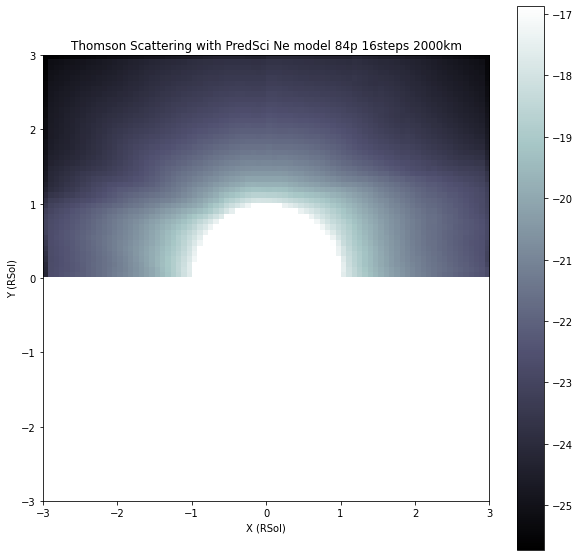

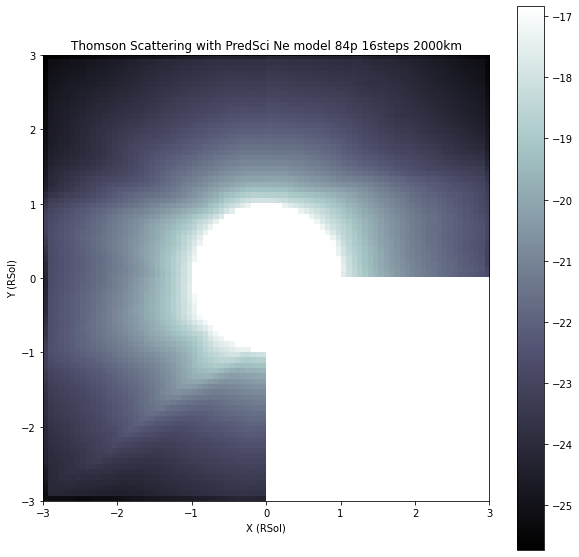

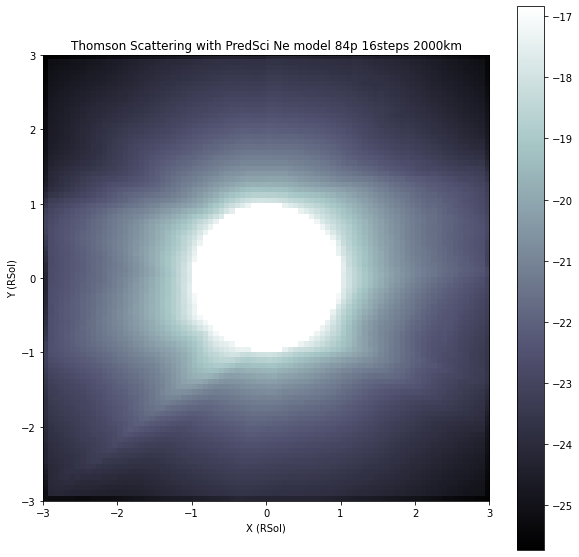

In [5]:
# Quadrant 1

x_min = [sip.IMAGE_NUM_POINTS // 2, 0, 0, sip.IMAGE_NUM_POINTS // 2]
print(x_min)
x_max = [sip.IMAGE_NUM_POINTS, sip.IMAGE_NUM_POINTS // 2, sip.IMAGE_NUM_POINTS // 2, sip.IMAGE_NUM_POINTS]
print(x_max)
y_min = [0, 0, sip.IMAGE_NUM_POINTS // 2, sip.IMAGE_NUM_POINTS // 2]
print(y_min)
y_max = [sip.IMAGE_NUM_POINTS // 2, sip.IMAGE_NUM_POINTS // 2, sip.IMAGE_NUM_POINTS, sip.IMAGE_NUM_POINTS]
print(y_max)

num_points = sip.IMAGE_NUM_POINTS * sip.IMAGE_NUM_POINTS
print(f"Num points = {num_points}")
count = 0

ini_time = time.perf_counter()

for m in range(1, 4):
    print("Loading octree...")
    NE_MODEL = octr.Octree.load(octree_paths[m])
    print("Octree loaded.")
    for y in range(y_min[m], y_max[m]):
        for x in range(x_min[m], x_max[m]):
            #print(f"x = {x}, y = {y}")
            if (x_values[x]**2 + y_values[y]**2) > tsp.SOLAR_RADIUS**2:
                # Coordinates with the center of the Sun as Origin of the Reference System.
                target = (x_values[x], y_values[y], 0)
                #print(target * units.METERS_TO_RSOL)
                # Creates a ThomsonGeometry object to manage the ray - tracing across the Corona.
                TG = thtools.ThomsonGeometry(sip.SUN_CENTER, sip.OBSERVER, target, tsp.SOLAR_RADIUS)

                # Line of sight integration generating a value for the scattered light model.
                scattered_light = thtools.get_scattered_light(tsp.WAVELENGTH, tsp.T_SOL, tsp.X, TG.get_elongation(), tsp.INI_Z, tsp.FIN_Z, tsp.INCR_Z, TG, NE_MODEL)
                model[y][x] = scattered_light
            else:
                model[y][x] = 0

            # Progress
            count += 1
            if count % 200 == 0:
                print("Progress", count / num_points * 100,"%")

    plt.figure(figsize=(10, 10))
    plt.title("Thomson Scattering with PredSci Ne model 84p 16steps 2000km")
    plt.ylabel("Y (RSol)")
    plt.xlabel("X (RSol)")
    model_log = np.log(model) / np.log(7) 
    plt.imshow(model_log, 
               cmap = 'bone', 
               interpolation = 'antialiased',
               interpolation_stage = 'data',
    #           vmin = -20, 
    #           vmax = -15,
               extent=[sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL])
    plt.colorbar()

fin_time = time.perf_counter()
print("Model built in", str((fin_time - ini_time) / 60), "minutes.")

fmt.dump(f"../../{paths.MODELS_PATH}allsun_3R_84p_16s.np", model)


/tmp/ipykernel_10489/2511103069.py:28: RuntimeWarning: divide by zero encountered in log
  model_log = np.log(model) / np.log(7)


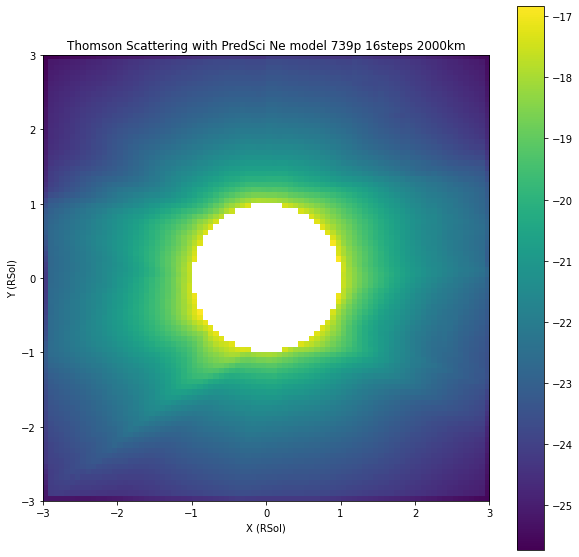

In [13]:
"""
Visualization of the ThomsonScattering.
"""
"""
cmap
['rainbow', 'nipy_spectral', 'gist_ncar', 'viridis', 'twilight', 'twilight_shifted', 'bone']
"""

"""
interpolation
'none', 'antialiased', 'nearest', 'bilinear', 
'bicubic', 'spline16', 'spline36', 'hanning', 
'hamming', 'hermite', 'kaiser', 'quadric', 
'catrom', 'gaussian', 'bessel', 'mitchell', 
'sinc', 'lanczos', 'blackman'

"""

"""
interpolation_stage{'data', 'rgba'}, default: 'data'
"""
model = fmt.load(f"../../{paths.MODELS_PATH}allsun_3R_84p_16s.np")

plt.figure(figsize=(10, 10))
plt.title("Thomson Scattering with PredSci Ne model 739p 16steps 2000km")
plt.ylabel("Y (RSol)")
plt.xlabel("X (RSol)")
model_log = np.log(model) / np.log(7) 
plt.imshow(model_log, 
           cmap = 'viridis', 
           interpolation = 'antialiased',
           interpolation_stage = 'data',
           #vmin = -25, 
           #vmax = -20,
           extent=[sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL])
plt.colorbar()

In [ ]:
"""
Models comparison
"""
def imshow_model(model, description, ax, fig, **kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
                                  
    im = ax.imshow(model, **kwargs)

    ax.set_xlabel(f" X [RSol]") # Set the axis label in the form "Variable description [units]"
    ax.set_ylabel(f" Y [RSol]") # Set the axis label in the form "Variable description [units]"
    ax.set_title(description)

    #ax.legend()
    fig.colorbar(im, cax = cax, orientation = 'vertical')

In [ ]:
model_739p_16steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_test_739p_16steps.np")
model_148p_16steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_octree_148p_16steps.np")
model_148p_8steps = fmt.load(f"../../{paths.MODELS_PATH}predsci_octree_148p_8steps.np")
desc1 = "Thomson Scattering with PredSci Ne model 148p 8steps"
desc2 = "Thomson Scattering with PredSci Ne model 148p 16steps"
desc3 = "Thomson Scattering with PredSci Ne model 739p 16steps 2000km"

my_models = [model_148p_8steps, model_148p_16steps, model_739p_16steps]
my_models = [np.divide(np.log(i), np.log(10)) for i in my_models] 
my_desc = [desc1, desc2, desc3]
my_cmap = 'twilight_shifted'
my_interp = 'antialiased'
my_interp_stage = 'data'
my_vmin = -18
my_vmax = -10
my_extent = [sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL, sip.MIN_COORD * units.METERS_TO_RSOL, sip.MAX_COORD * units.METERS_TO_RSOL]

fig, ax = plt.subplots(ncols=3, figsize=(50, 40))   # We can select ncols, nrows, or both.

for i in range(3):
    imshow_model(my_models[i], my_desc[i], ax[i], fig, cmap = my_cmap, interpolation = my_interp, vmin = my_vmin, vmax = my_vmax, interpolation_stage = my_interp_stage, extent = my_extent)


In [ ]:
fig.savefig(f"../../{paths.MODELS_PATH}predsci_comparison.jpg")